In [1]:
%reload_ext autoreload
%autoreload 2

# OP apportionment

Weber S, ...

## Abstract

Oxidative potential (OP) has been proposed as a measure of toxicity of PM...

## Introduction

...

## Methodology

### Sampling sites

### Analysis

#### Chemical

#### OP AA/DTT(/DCFH?)

### Statistical framework

#### PMF
Blabla

Evolution from the SOURCES programme: SOURCESv2

PMF profils:

- base run (same as SOURCES) 
- constraints (same as SOURCES)
- Bootstrap
- mean of bootstrap as reference for the profils (SOURCESv2, not from the ref. constraint run)
- PM contribution reconstructed from the mean PM of each bootstrap profils (SOURCESv2, not from the ref. constraint run) 

#### Mulitple linear regression




In [2]:
import pandas as pd
import statsmodels.api as sm 
from statsmodels.tools.tools import add_constant

def solve_WLS(X=None, y=None, sigma=None):
    """
    Solve a multiple linear problem using statsmodels WLS with positivity constraint
    according to Weber et al. (2018)
    """
    goForWLS = add_constant(X.copy())
    regr = sm.WLS(y, goForWLS, weights=sigma, cov_type="fixed_scale").fit()
    while True:
        regr = sm.WLS(y, goForWLS, weights=sigma, cov_type="fixed_scale").fit()
        paramstmp=regr.params.copy()
        paramstmp["const"]=10
        # if (regr.pvalues > 0.05).any():
        if (paramstmp < 0).any():
            # Some variable are 0, drop them.
            # goForWLS.drop(goForWLS.columns[regr.pvalues>0.05],axis=1,inplace=True)
            # goForWLS.drop(goForWLS.columns[regr.pvalues == max(regr.pvalues)],axis=1,inplace=True)
            goForWLS.drop(goForWLS.columns[paramstmp == min(paramstmp)],axis=1,inplace=True)
            # print(regr.summary())
        else:
            # Ok, the run converged
            break
        if goForWLS.shape[1]==0:
            # All variable were droped... Pb
            print("Warning: The run did not converge...")
            break
    # print(regr.summary())
    return regr

/home/webersa/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Results

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from Station import Station
%matplotlib notebook

dbPM = "/home/webersa/Documents/BdD/BdD_PM/db.sqlite"
conn = sqlite3.connect(dbPM)
dfPMF_all = pd.read_sql("SELECT * FROM PMF_contributions WHERE station IN ('Pipiripi');", conn)
dfPMF_all.dropna(axis=1, how="all", inplace=True)
dfPM_all = pd.read_sql("SELECT * FROM values_all;", conn)
conn.close()

list_OPtype = ["DTTv", "DCFHv"]
list_station = ["Pipiripi"]#dfPMF_all["station"].unique()
NBOOT = 50

list_station.sort()
list_OPtype.sort()
sto = {}
for name in list_station:
    if name == "Rouen":
        continue

    print(name)
    station = Station(name=name, list_OPtype=list_OPtype)
    station.load_SRC(dfPMF_all[dfPMF_all["station"]==name])
    print(station.SRC.columns)
    station.SRC.rename({"HFO":"Traffic_non-exhaust"}, axis=1, inplace=True)
    station.setSourcesCategories()
    if "Lens-2011" in name:
        name = "Lens"
    station.load_OP(dfPM_all[dfPM_all["station"]==name])
    station.OPi = pd.DataFrame(index=station.SRC.columns, columns=list_OPtype)
    
    for OPtype in list_OPtype:
        if not(OPtype in station.OP.columns) or station.OP[OPtype].isnull().all() or station.OP[OPtype].empty:
            print("WARNING: no OP {}".format(OPtype))
            continue
        
        df = station.SRC.merge(station.OP[[OPtype, "SD_"+OPtype]], left_index=True, right_index=True, how="inner")
        
        # drop known extreme value
        mask_outliers = [False] * len(df.index)
        if name == "GRE-fr":
            mask_outliers = df.index != pd.to_datetime('2013-04-26')
            df = df[mask_outliers]
        
        df.dropna(inplace=True)
        if len(df)<=50:
            print("WARNING: not enought commun index: {}".format(len(df)))
            continue
        OP = df[OPtype]
        OPunc = df["SD_"+OPtype]
        SRC = df[station.SRC.columns]
        OP.name = OPunc.name = SRC.name = name
        
        # solve WLS
        regr = solve_WLS(X=SRC, y=OP, sigma=1/OPunc**2)
        station.reg[OPtype] = regr
        station.OPi.loc[:, OPtype] = regr.params[1:]
        station.OPi.loc[:, "SD_"+OPtype] = regr.bse[1:]
        station.OPi.sort_index(inplace=True)
        
        # Bootstrap solution
        pred = pd.DataFrame(index=SRC.index)
        for i in range(NBOOT):
            params = regr.bse * np.random.randn(len(regr.params)) + regr.params
            pred[i] = (params*SRC).sum(axis=1) + params["const"]
        station.OPmodel_unc[OPtype] = pred.std(axis=1)
        station.OPmodel[OPtype] = regr.params["const"]+(station.SRC * station.OPi[OPtype]).sum(axis=1)

    sto[name] = station

Pipiripi
Index(['Biomass burning', 'HFO', 'Mineral dust', 'Nitrate rich',
       'Primary biogenic', 'Road traffic', 'Sea/road salt', 'Sulfate rich'],
      dtype='object')


/home/webersa/.local/lib/python3.5/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/webersa/.local/lib/python3.5/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


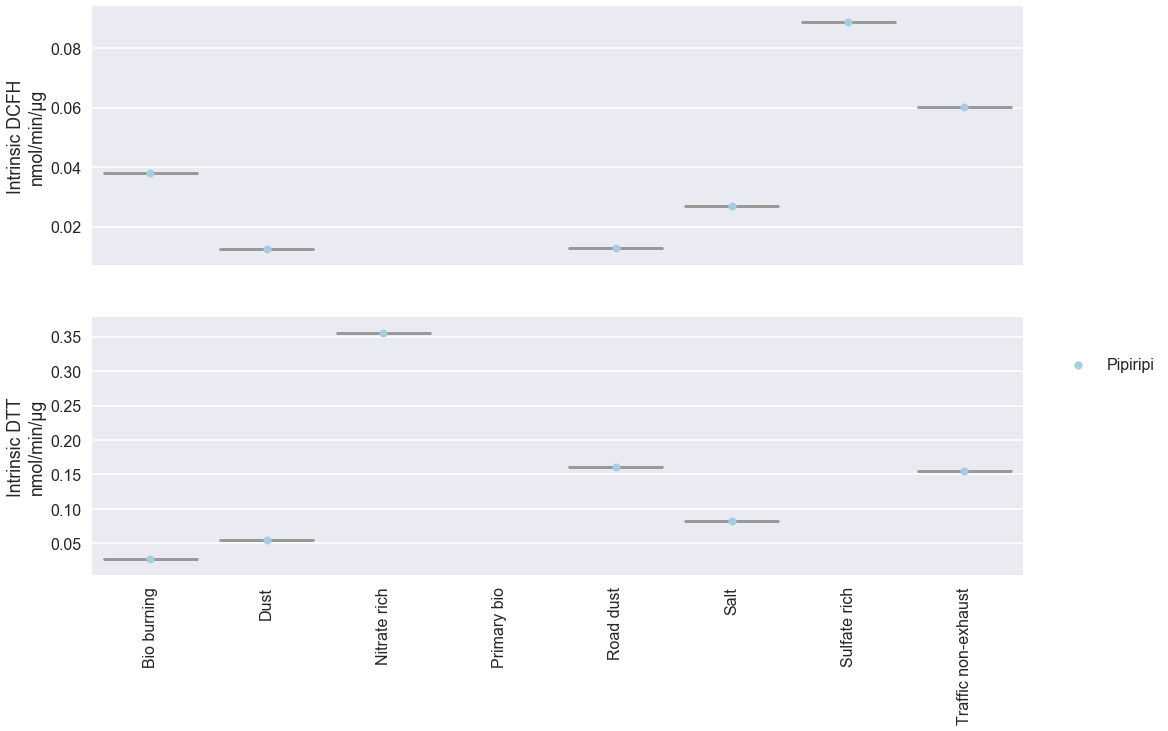

In [8]:
%matplotlib inline
from scripts.plot_utility import *
sns.set()
sns.set_context("poster")
plot_coeff_all_boxplot(sto, list_OPtype)

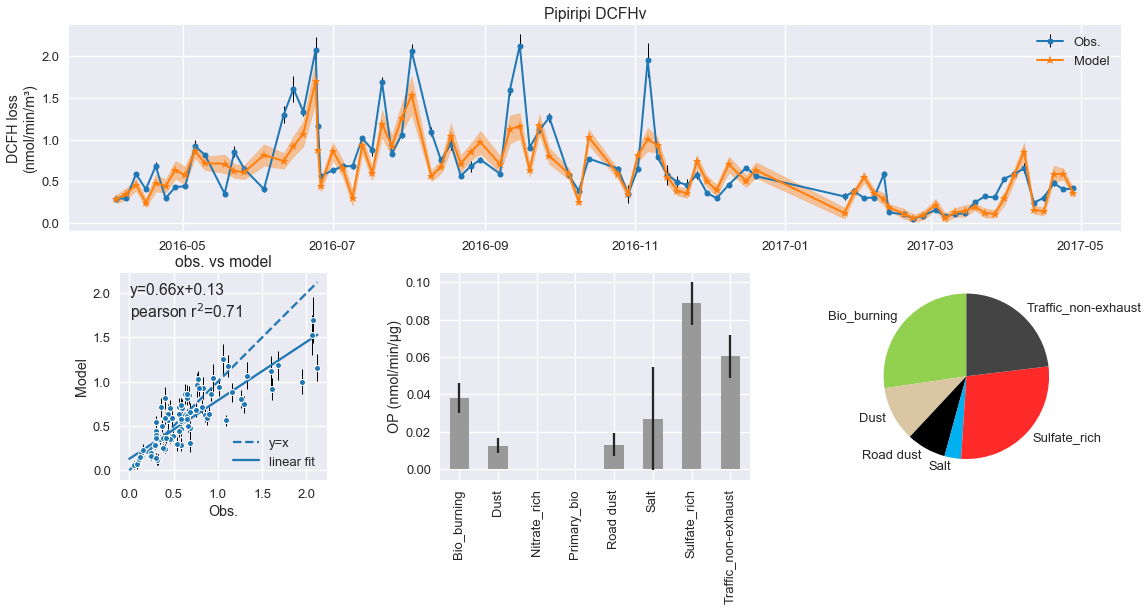

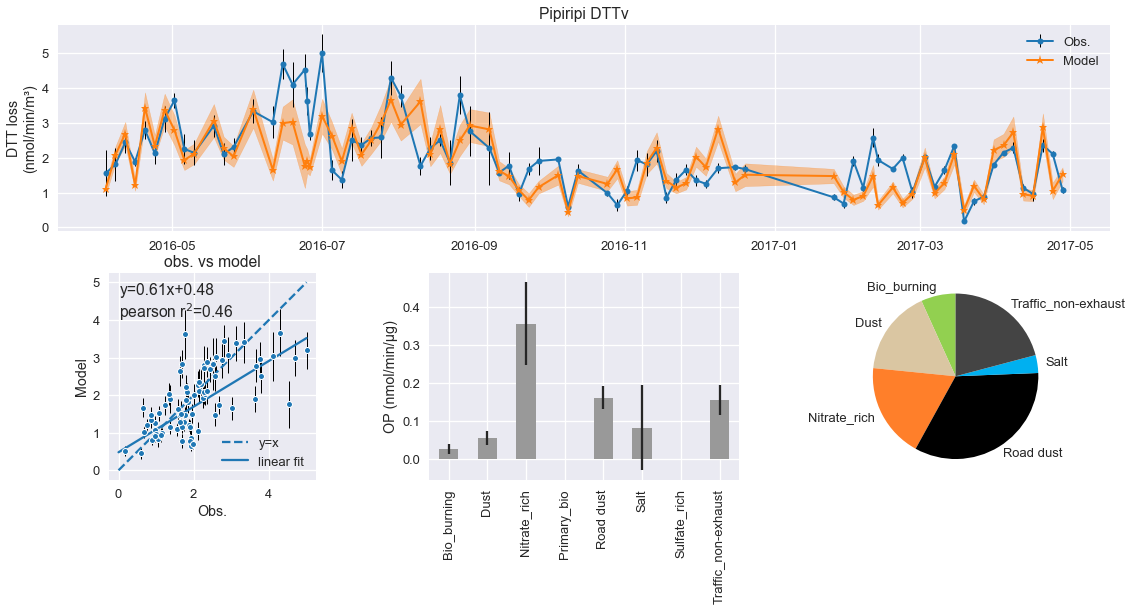

In [46]:
%matplotlib inline
sns.set_context("talk")
for OPtype in list_OPtype:
    for station in list_station: 
        if "Lens" in station: 
            station = "Lens"
        if sto[station].OP[OPtype].empty or sto[station].OPmodel[OPtype].isnull().all():
            continue
        if "Talence" in station:
            continue
        plot_station(sto[station], OPtype)
        #plot_save(OPtype+station, "/home/webersa/")
        

Text(0,0.5,'OP DTTv')

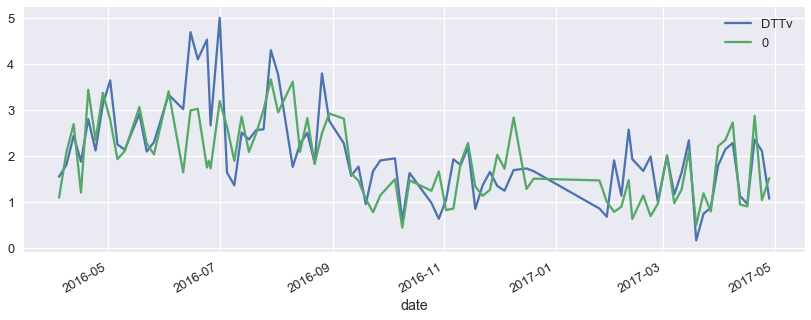

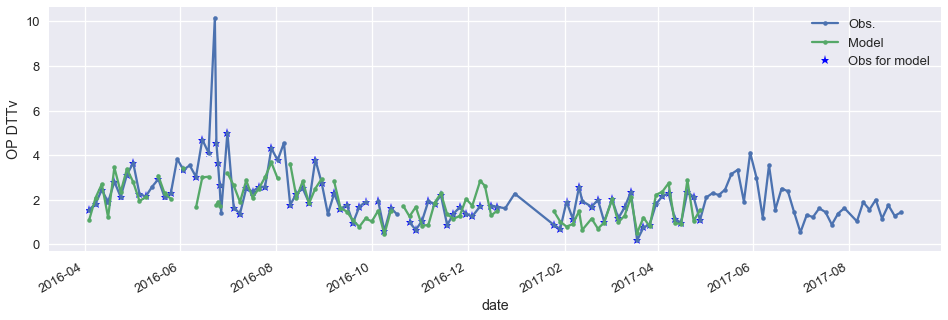

In [99]:
df1 = pd.concat([s.OP.loc[idx,OPtype], s.reg[OPtype].fittedvalues[idx]], axis=1)
df2 = pd.concat([s.OP[OPtype], s.OPmodel[OPtype], s.SRC["Bio_burning"]], axis=1)
df2.columns = ["Obs", "Model", "Bio_burning"]
df2.loc[df2.Bio_burning.isna(),"Model"] = pd.np.nan 
df2.drop("Bio_burning", inplace=True, axis=1)
df1.plot(figsize=(14,5))
ax=df2.plot(figsize=(16,5), marker=".")
df1["DTTv"].plot(ax=ax, marker="*", color="blue", linestyle="", zorder=-1)
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["Obs.", "Model", "Obs for model"])
ax.set_ylabel("OP DTTv")

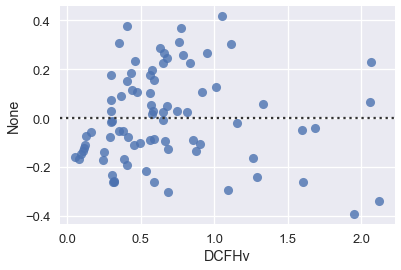

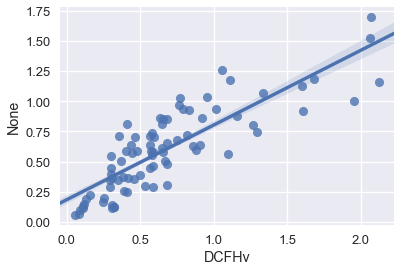

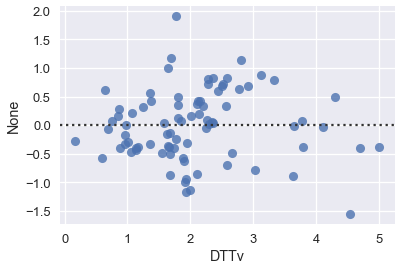

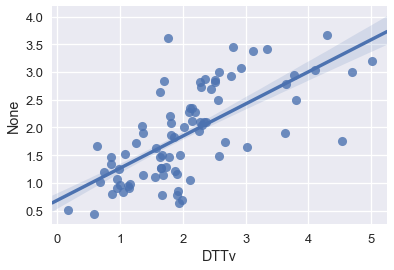

In [18]:
%matplotlib inline
s=sto["Pipiripi"]
for OPtype in list_OPtype:
    idx=  s.OP[OPtype].index.intersection(s.reg[OPtype].fittedvalues.index)
    plt.figure()
    sns.residplot(s.OP.loc[idx,OPtype], s.reg[OPtype].fittedvalues[idx])
    plt.figure()
    sns.regplot(s.OP.loc[idx,OPtype], s.reg[OPtype].fittedvalues[idx], ci=68)

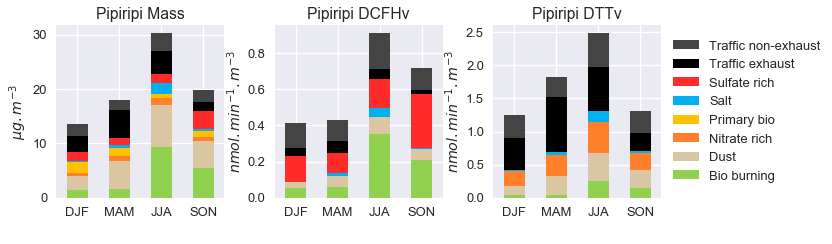

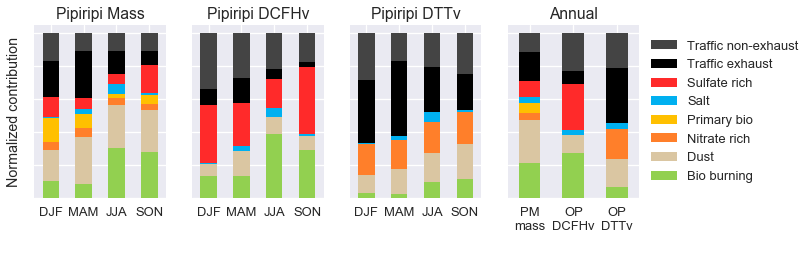

In [12]:
sns.set_context("talk")

for station in sto.values():
    if station.name not in ["Pipiripi"]: #["Chamonix", "GRE-fr", "MRS-5av"]:
        continue
    #plot_barplot_contribution(station, ["AAv", "DTTv"])
    plot_barplot_contribution(station, list_OPtype, normalize=False)

for station in sto.values():
    if station.name not in ["Pipiripi"]: #["Chamonix", "GRE-fr", "MRS-5av"]:
        continue
    #plot_barplot_contribution(station, ["AAv", "DTTv"])
    plot_barplot_contribution(station, list_OPtype, normalize=True)
   

In [8]:
sto["Pipiripi"].OP


,SD_DCFHv,DCFHv,DTTv,SD_DTTv
date,,,,
2016-04-04,0.00867,0.29494,1.55211,0.66043
2016-04-08,0.01016,0.29619,1.81055,0.47192
2016-04-12,0.00829,0.58777,2.44282,0.30381
2016-04-16,0.02545,0.40641,1.88222,0.11192
2016-04-20,0.04445,0.68324,2.80284,0.26298
2016-04-24,0.01416,0.29836,2.12311,0.29962
2016-04-28,0.01104,0.43441,3.12471,0.37093
2016-05-02,0.02082,0.44135,3.64699,0.22694
2016-05-06,0.07633,0.92012,2.25324,0.43438


In [9]:
plot_seasonal_contribution(sto["Chamonix"], "AAv", normalize=False)

KeyError: 'Chamonix'

In [ ]:
for name in ["Chamonix","GRE-fr","MRS-5av"]:
    plot_barplot_contribution(sto[name], list_OPtype=list_OPtype, normalize=False)